In [2]:
import pandas as pd

## Dealing with Data Types

In [3]:
## Add parse dates to convert tstp to datetime

df = pd.read_csv('block_0.csv', parse_dates=['tstp'])

In [4]:
df

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00,0
1,MAC000002,2012-10-12 01:00:00,0
2,MAC000002,2012-10-12 01:30:00,0
3,MAC000002,2012-10-12 02:00:00,0
4,MAC000002,2012-10-12 02:30:00,0
...,...,...,...
1222665,MAC005492,2014-02-27 22:00:00,0.182
1222666,MAC005492,2014-02-27 22:30:00,0.122
1222667,MAC005492,2014-02-27 23:00:00,0.14
1222668,MAC005492,2014-02-27 23:30:00,0.192


In [5]:
# Select only a single LCLid for analysis

df1 = df[df['LCLid'] == 'MAC000002']

In [6]:
# Nulls are written as strings in the energy column

df1[['energy(kWh/hh)']].value_counts()

energy(kWh/hh)
 0.123            225
 0.125            219
 0.119            215
 0.116            213
 0.118            212
                 ... 
 1.211              1
 0.79               1
 1.2079999          1
 1.207              1
Null                1
Name: count, Length: 1332, dtype: int64

In [7]:
# Inspect the null entries

df1.loc[df['energy(kWh/hh)'] == 'Null']

,LCLid,tstp,energy(kWh/hh)
3238,MAC000002,2012-12-19 12:37:27,Null


In [8]:
# Replace 'Null' strings with 0

df1.replace('Null', 0, inplace=True)

/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_8269/2731956260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('Null', 0, inplace=True)


In [9]:
# Set the energy column to numeric

df1['energy(kWh/hh)'] = pd.to_numeric(df1['energy(kWh/hh)'])

/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_8269/4013696799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['energy(kWh/hh)'] = pd.to_numeric(df1['energy(kWh/hh)'])


## Plotting the data

In [10]:
df1 = df1.sort_values('tstp')

<Axes: title={'center': 'Half-hourly consumption for LCLid MAC000002'}, xlabel='tstp'>

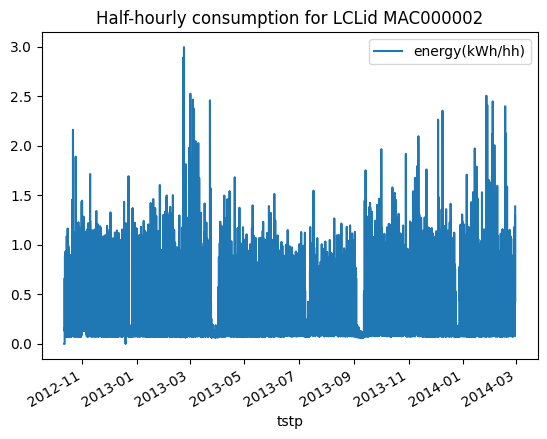

In [11]:
df1.plot(x='tstp', y='energy(kWh/hh)', kind='line', title='Half-hourly consumption for LCLid MAC000002')

## Train test split

In [12]:
train_size = 0.6
index = round(train_size*df1.shape[0])

df_train = df1.iloc[:index]
df_test = df1.iloc[index:]

## Linear model 12 autoregressive features

In [13]:
df2 = df1.copy(); df2_train = df_train.copy(); df2_test = df_test.copy()

for i in range(1, 97):
    df2_train[f't - {i}'] = df_train['energy(kWh/hh)'].shift(i)
    df2_test[f't - {i}'] = df_test['energy(kWh/hh)'].shift(i)

df2_train.dropna(inplace=True)
df2_test.dropna(inplace=True)

df2_test.head()

,LCLid,tstp,energy(kWh/hh),t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,...,t - 87,t - 88,t - 89,t - 90,t - 91,t - 92,t - 93,t - 94,t - 95,t - 96
14581,MAC000002,2013-08-12 20:00:00,0.174,0.173,1.096,0.131,0.153,0.216,0.136,0.139,...,0.138,0.157,0.191,0.165,0.186,0.176,0.188,0.155,0.189,0.160
14582,MAC000002,2013-08-12 20:30:00,0.197,0.174,0.173,1.096,0.131,0.153,0.216,0.136,...,0.106,0.138,0.157,0.191,0.165,0.186,0.176,0.188,0.155,0.189
14583,MAC000002,2013-08-12 21:00:00,0.209,0.197,0.174,0.173,1.096,0.131,0.153,0.216,...,0.119,0.106,0.138,0.157,0.191,0.165,0.186,0.176,0.188,0.155
14584,MAC000002,2013-08-12 21:30:00,0.190,0.209,0.197,0.174,0.173,1.096,0.131,0.153,...,0.107,0.119,0.106,0.138,0.157,0.191,0.165,0.186,0.176,0.188
14585,MAC000002,2013-08-12 22:00:00,0.218,0.190,0.209,0.197,0.174,0.173,1.096,0.131,...,0.117,0.107,0.119,0.106,0.138,0.157,0.191,0.165,0.186,0.176


## Testing autoregressive model

In [14]:
from sklearn.metrics import r2_score

In [15]:
X2_train = df2_train.drop(columns = ['tstp','LCLid',"energy(kWh/hh)"])
y2_train = df2_train["energy(kWh/hh)"]
X2_test = df2_test.drop(columns = ['tstp','LCLid',"energy(kWh/hh)"])
y2_test = df2_test["energy(kWh/hh)"]

print(X2_train.shape,y2_train.shape, X2_test.shape,y2_test.shape)

(14389, 96) (14389,) (9560, 96) (9560,)


In [16]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

R2:  0.5460098980283684


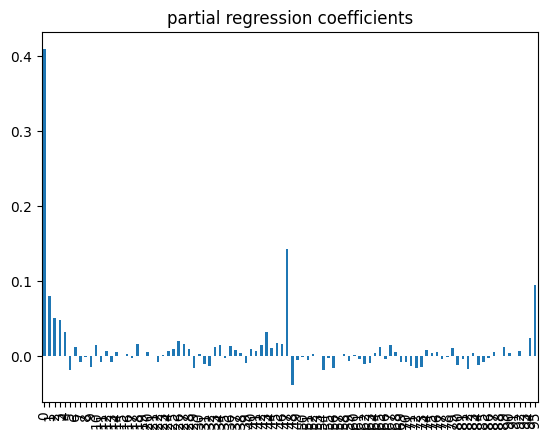

In [17]:
# Predict and measure R2
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

## Decomposition

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_8269/3425055928.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  series = df1.set_index('tstp').sort_index()['energy(kWh/hh)'].asfreq('30T').fillna(method='ffill')
/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_8269/3425055928.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df1.set_index('tstp').sort_index()['energy(kWh/hh)'].asfreq('30T').fillna(method='ffill')


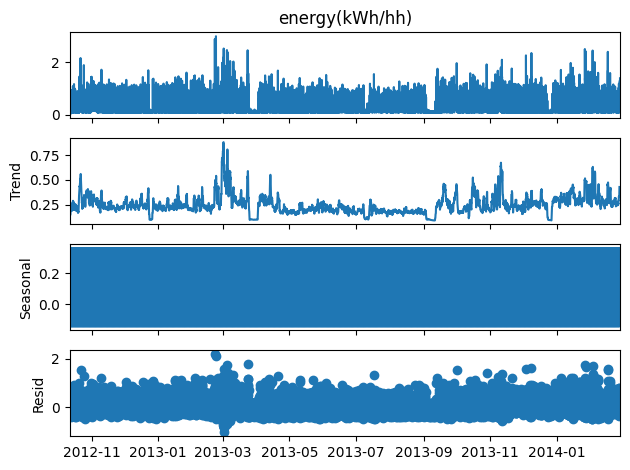

In [19]:
# ensure a DatetimeIndex with a freq, then decompose with a chosen period (48 = daily for 30min data)
series = df1.set_index('tstp').sort_index()['energy(kWh/hh)'].asfreq('30T').fillna(method='ffill')
result_add = seasonal_decompose(series, model='additive', period=48)
result_add.plot();

/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_8269/1937091470.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  series = df1.set_index('tstp').sort_index()['energy(kWh/hh)'].asfreq('30T').fillna(method='ffill')
/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_8269/1937091470.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df1.set_index('tstp').sort_index()['energy(kWh/hh)'].asfreq('30T').fillna(method='ffill')


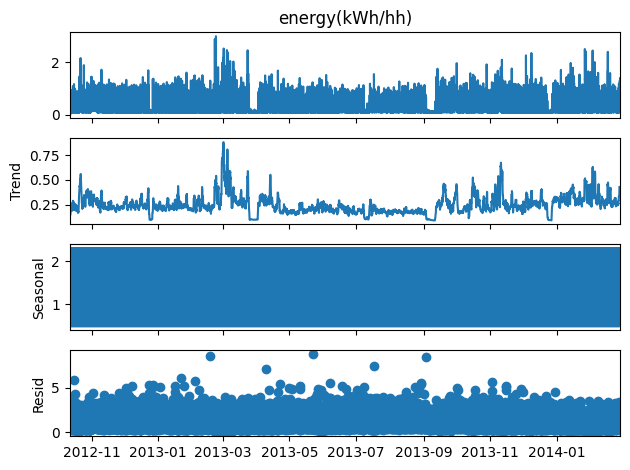

In [20]:
import numpy as np

# ensure a DatetimeIndex with a freq, then decompose with a chosen period (48 = daily for 30min data)
series = df1.set_index('tstp').sort_index()['energy(kWh/hh)'].asfreq('30T').fillna(method='ffill')

# multiplicative decomposition requires strictly positive values — replace non-positive values with a small epsilon
epsilon = 1e-6
series_pos = series.clip(lower=epsilon)

result_mul = seasonal_decompose(series_pos, model='multiplicative', period=48)
result_mul.plot();

In [21]:
series

tstp
2012-10-12 00:30:00    0.000
2012-10-12 01:00:00    0.000
2012-10-12 01:30:00    0.000
2012-10-12 02:00:00    0.000
2012-10-12 02:30:00    0.000
                       ...  
2014-02-27 22:00:00    0.416
2014-02-27 22:30:00    1.350
2014-02-27 23:00:00    1.247
2014-02-27 23:30:00    1.218
2014-02-28 00:00:00    1.387
Freq: 30min, Name: energy(kWh/hh), Length: 24192, dtype: float64

In [22]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    s = series.dropna()  # drop edge NaNs from decomposition
    stat, pval, _, _, crit, _ = adfuller(s)
    print(f"{name}: ADF={stat:.4f}, p={pval:.4g}")
    for k, v in crit.items():
        print(f"   {k} crit: {v:.4f}")
    print()

for label, comp in [
    ("additive observed", result_add.observed),
    ("additive trend", result_add.trend),
    ("additive seasonal", result_add.seasonal),
    ("additive resid", result_add.resid),
    ("multiplicative observed", result_mul.observed),
    ("multiplicative trend", result_mul.trend),
    ("multiplicative seasonal", result_mul.seasonal),
    ("multiplicative resid", result_mul.resid),
]:
    adf_test(comp, label)


additive observed: ADF=-9.9005, p=3.367e-17
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668

additive trend: ADF=-6.5719, p=7.899e-09
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668

additive seasonal: ADF=-2420339710093253.5000, p=0
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668

additive resid: ADF=-38.5218, p=0
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668

multiplicative observed: ADF=-9.9005, p=3.367e-17
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668

multiplicative trend: ADF=-6.5719, p=7.899e-09
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668

multiplicative seasonal: ADF=-20809017456349.8398, p=0
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668

multiplicative resid: ADF=-24.0577, p=0
   1% crit: -3.4306
   5% crit: -2.8617
   10% crit: -2.5668



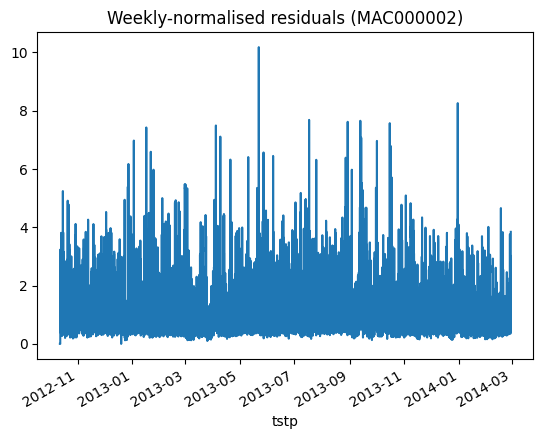

In [23]:
# Weekly trend + weekly seasonality removal (half-hourly slots across the week)
df_week = df1[['tstp', 'energy(kWh/hh)']].sort_values('tstp').copy()

# Smooth weekly trend: 7 days * 48 half-hour slots
trend_window = 48 * 7
df_week['trend'] = (
    df_week['energy(kWh/hh)']
    .rolling(trend_window, min_periods=trend_window // 2)
    .mean()
    .bfill()
)

# Remove trend
df_week['trend_stripped'] = df_week['energy(kWh/hh)'] / df_week['trend']

# Capture weekly pattern by day-of-week and half-hour slot
df_week['dow'] = df_week['tstp'].dt.dayofweek              # 0=Mon … 6=Sun
df_week['slot'] = df_week['tstp'].dt.hour * 2 + (df_week['tstp'].dt.minute // 30)  # 0..47

weekly_means = (
    df_week.groupby(['dow', 'slot'])['trend_stripped']
    .mean()
    .rename('weekly_value')
    .reset_index()
)

# Merge weekly component back and compute residuals
joined_w = df_week.merge(weekly_means, on=['dow', 'slot'], how='left')
joined_w['residuals'] = joined_w['trend_stripped'] / joined_w['weekly_value']

# Quick look
joined_w.set_index('tstp')['residuals'].plot(title='Weekly-normalised residuals (MAC000002)');

## Stationarity checks and differencing
Check stationarity and prepare a differenced series to feed into ARIMA/SARIMA.

/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_8269/3036804767.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .asfreq('30T')


ADF on candidate transformations:
original: ADF=-9.895, p=0.0000
   crit: 1%:-3.431, 5%:-2.862, 10%:-2.567
   stationary? yes
1st diff: ADF=-51.121, p=0.0000
   crit: 1%:-3.431, 5%:-2.862, 10%:-2.567
   stationary? yes
seasonal diff (48): ADF=-33.971, p=0.0000
   crit: 1%:-3.431, 5%:-2.862, 10%:-2.567
   stationary? yes
1st + seasonal diff: ADF=-26.398, p=0.0000
   crit: 1%:-3.431, 5%:-2.862, 10%:-2.567
   stationary? yes


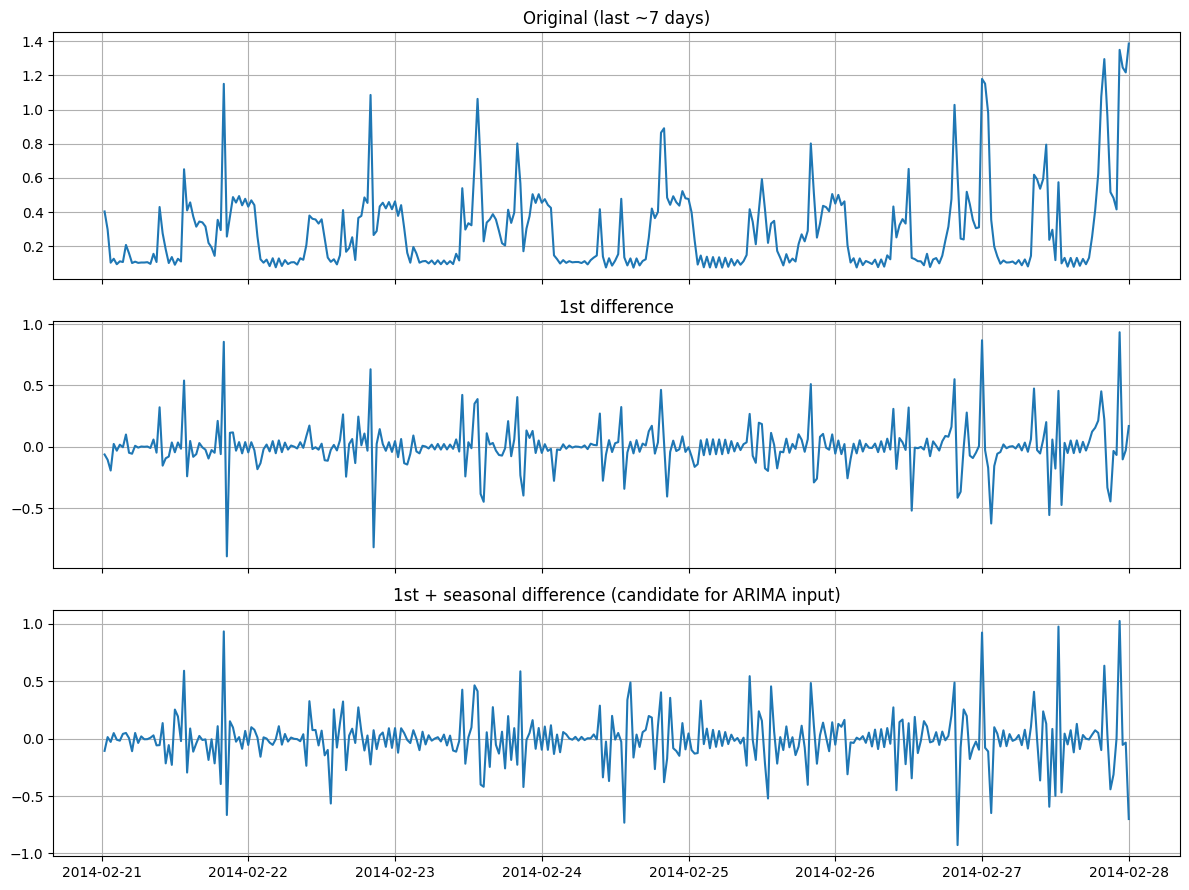

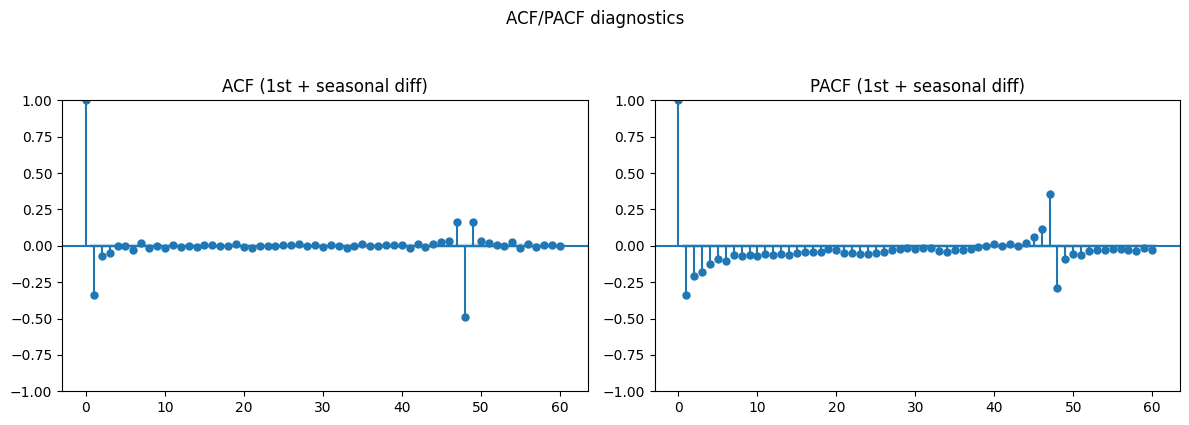

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# clean univariate series with a fixed freq for modeling
series = (
    df1.set_index('tstp')
    .sort_index()['energy(kWh/hh)']
    .asfreq('30T')
    .interpolate('time')
    .bfill()
)


def adf_summary(s, label):
    s = s.dropna()
    stat, pval, usedlag, nobs, crit, _ = adfuller(s)
    print(f"{label}: ADF={stat:.3f}, p={pval:.4f}")
    print("   crit:", ", ".join(f"{k}:{v:.3f}" for k, v in crit.items()))
    print(f"   stationary? {'yes' if pval < 0.05 else 'no'}")

print("ADF on candidate transformations:")
adf_summary(series, "original")
series_diff = series.diff()
adf_summary(series_diff, "1st diff")
series_seasonal = series.diff(48)
adf_summary(series_seasonal, "seasonal diff (48)")
series_combined = series_diff.diff(48)
adf_summary(series_combined, "1st + seasonal diff")

# quick look at recent window of each transform to inspect stability
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
axes[0].plot(series.tail(336))
axes[0].set_title('Original (last ~7 days)')
axes[1].plot(series_diff.tail(336))
axes[1].set_title('1st difference')
axes[2].plot(series_combined.tail(336))
axes[2].set_title('1st + seasonal difference (candidate for ARIMA input)')
for ax in axes:
    ax.grid(True)
fig.tight_layout()
plt.show()

# ACF/PACF on the most stationary candidate to guide (p,q) and (P,Q)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series_combined.dropna(), lags=60, ax=axes[0])
axes[0].set_title('ACF (1st + seasonal diff)')
plot_pacf(series_combined.dropna(), lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF (1st + seasonal diff)')
fig.suptitle('ACF/PACF diagnostics', y=1.05)
fig.tight_layout()
plt.show()

# choose a modeling series for ARIMA/SARIMA
stationary_series = series_combined.dropna()

## Baseline SARIMA fit
Split train/validation and fit a first SARIMA model; adjust orders after checking residuals.


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [26]:
# use the cleaned series with fixed freq
series_full = series.dropna()

In [27]:
# simple hold-out: reserve the last day (48 half-hours) for validation
horizon = 48
train = series_full.iloc[:-horizon]
valid = series_full.iloc[-horizon:]

In [28]:
# initial SARIMA order guess informed by ACF/PACF (daily seasonality=48)
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 48)

In [ ]:
model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     energy(kWh/hh)   No. Observations:                24144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 48)   Log Likelihood                7874.607
Date:                            Wed, 17 Dec 2025   AIC                         -15741.213
Time:                                    15:43:28   BIC                         -15708.863
Sample:                                10-12-2012   HQIC                        -15730.723
                                     - 02-27-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4879      0.003    150.807      0.000       0.482       0.494
ma.L1         -0.9805      0.001   

In [29]:
# forecast the validation window and the next half-hour beyond it
forecast_steps = len(valid) + 1
pred = results.get_forecast(steps=forecast_steps)
forecast = pred.predicted_mean

NameError: name 'results' is not defined

In [ ]:
# align forecasts with index for plotting/metrics
forecast_index = valid.index.append(
    valid.index[-1:] + pd.to_timedelta('30T')
)
forecast = forecast.set_axis(forecast_index)

/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_98439/2031704061.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  valid.index[-1:] + pd.to_timedelta('30T')


In [ ]:
mae = mean_absolute_error(valid, forecast.iloc[:-1])
print(f"Validation MAE over last {horizon/48:.1f} days: {mae:.4f}")

Validation MAE over last 1.0 days: 0.2071


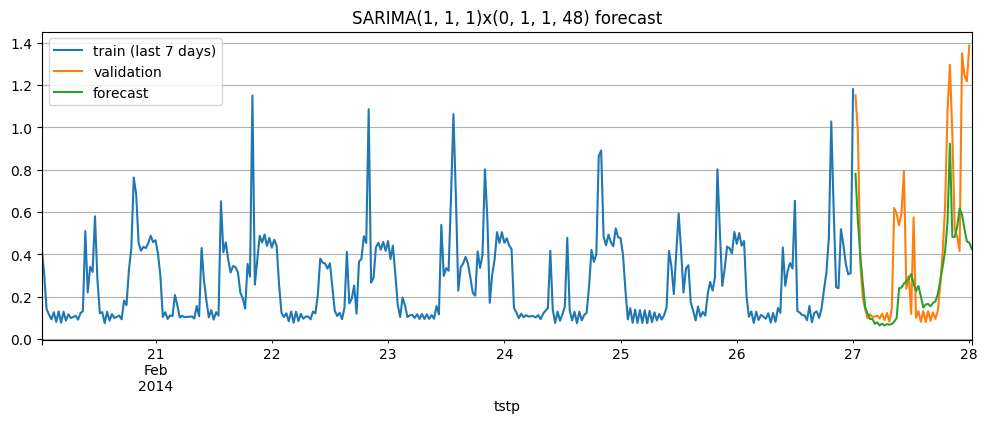

In [ ]:
# plot train, validation, and forecast
fig, ax = plt.subplots(figsize=(12,4))
train.tail(7*48).plot(ax=ax, label='train (last 7 days)')
valid.plot(ax=ax, label='validation')
forecast.plot(ax=ax, label='forecast')
ax.legend()
ax.set_title(f'SARIMA{order}x{seasonal_order} forecast')
ax.grid(True)
plt.show()

## Out-of-season check (July holdout)
Train on data before July and test on an early-July window to see seasonal drift.


In [30]:
# define a July window for holdout
july_start = '2013-07-01'
july_end = '2013-07-08'  # one week

In [31]:
series_full = series.dropna()

july_mask = (series_full.index >= july_start) & (series_full.index < july_end)
july_holdout = series_full.loc[july_mask]

if july_holdout.empty:
    raise ValueError("No data found in the selected July window; adjust july_start/july_end.")

In [32]:
# train on everything before the holdout window
train_july = series_full.loc[series_full.index < july_start]

print(f"Train samples: {len(train_july)}, July holdout samples: {len(july_holdout)}")

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 48)

Train samples: 12575, July holdout samples: 336


In [33]:
model_july = SARIMAX(
    train_july,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res_july = model_july.fit(disp=False)

/Users/eugeneleach/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# forecast the July window length
steps = len(july_holdout)
pred_july = res_july.get_forecast(steps=steps)
july_fc = pred_july.predicted_mean

In [35]:
# metrics
from sklearn.metrics import mean_absolute_error
mae_july = mean_absolute_error(july_holdout, july_fc)
print(f"July holdout MAE over {steps/48:.1f} days: {mae_july:.4f}")

July holdout MAE over 7.0 days: 0.0863


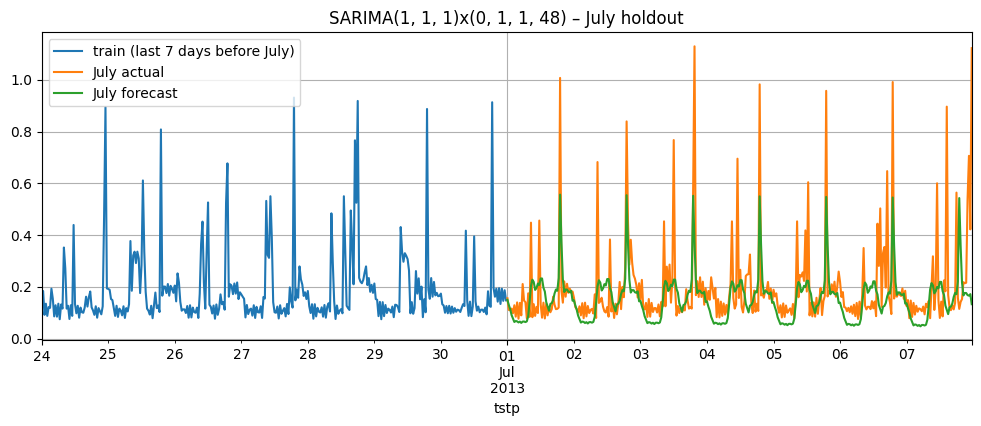

In [36]:
# plot
fig, ax = plt.subplots(figsize=(12,4))
train_july.tail(7*48).plot(ax=ax, label='train (last 7 days before July)')
july_holdout.plot(ax=ax, label='July actual')
july_fc.set_axis(july_holdout.index).plot(ax=ax, label='July forecast')
ax.legend()
ax.set_title(f'SARIMA{order}x{seasonal_order} – July holdout')
ax.grid(True)
plt.show()